# [cutoffs_and_troughs](https://github.com/ahijevyc/cutoffs_and_troughs) repo

In [1]:
import logging
import os
import pdb
from functools import partial
from pathlib import Path

import cartopy
import matplotlib.animation
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import HTML
from utils import animate, fmt, get_contains_zmin, get_location, loc2color, na_values

sns.set_theme(style="whitegrid")
logging.basicConfig(level=logging.WARNING, format="%(asctime)s %(message)s", force=True)

In [2]:
Lupo_init_times_Table2 = (
    "20160123",
    "20160427",
    "20170315",
    "20180310",
    "20190203",
    "20190529",
    "20191031",
    "20200411",
    "20200902",
    "20200908",
)

In [3]:
casedir = Path("/glade/campaign/mmm/parc/mwong/ufs-mrw")
workdir = Path(os.getenv("SCRATCH")) / "ks21_tmp"

# set extent
lon0 = 360 - 127
lon1 = 360 - 68
lat0 = 23
lat1 = 50
extent = (lon0, lon1, lat0, lat1)

case = pd.to_datetime("20220505T12")
# Choose a forecast length (24, 48, 72, or 240 work)
forecast_length = 72

datepos = 0
case_path_forecast_length = 240 if forecast_length == 96 else forecast_length
case_paths = sorted(casedir.glob(f"[12]?????????.F{case_path_forecast_length:03d}.C768"))

isensemble = False
if isensemble:
    case_paths = sorted(casedir.glob(f"E[12]?????????.p??.F{case_path_forecast_length:03d}.C768"))
    datepos = 1
itimes = [pd.to_datetime(c.name[datepos : datepos + 10], format=fmt) for c in case_paths]
print(f"found {len(itimes)} itimes with {forecast_length}-h forecasts in casedir {casedir}")
ITIME = case - pd.to_timedelta(f"{forecast_length}h")
print(f"ITIME {ITIME:%Y%m%d%H} case {case:%Y%m%d%H}")

pd.Series(itimes, name="itime")

found 24 itimes with 72-h forecasts in casedir /glade/campaign/mmm/parc/mwong/ufs-mrw
ITIME 2022050212 case 2022050512


0    2019-10-23 06:00:00
1    2019-11-24 06:00:00
2    2019-12-20 00:00:00
3    2020-02-09 06:00:00
4    2020-02-20 12:00:00
5    2020-03-01 00:00:00
6    2020-04-06 12:00:00
7    2020-04-09 12:00:00
8    2020-05-16 12:00:00
9    2020-08-29 18:00:00
10   2020-09-07 00:00:00
11   2020-10-25 18:00:00
12   2020-11-25 06:00:00
13   2021-03-14 18:00:00
14   2021-04-09 00:00:00
15   2021-04-11 12:00:00
16   2021-04-28 06:00:00
17   2021-10-16 18:00:00
18   2021-10-26 06:00:00
19   2021-12-31 06:00:00
20   2022-02-13 12:00:00
21   2022-04-11 06:00:00
22   2022-05-02 12:00:00
23   2022-06-11 18:00:00
Name: itime, dtype: datetime64[ns]

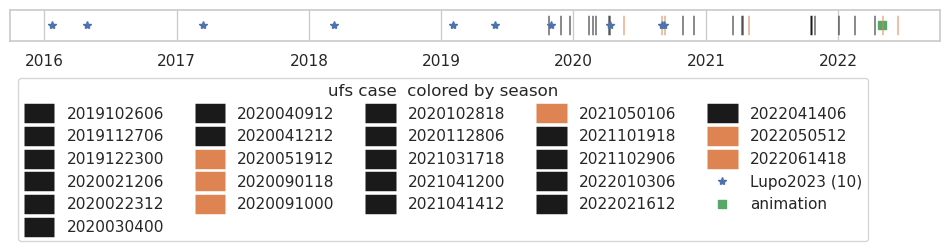

In [4]:
fig, ax = plt.subplots(figsize=(12, 0.4))
ax.plot()
# Major ticks every half year, minor ticks every month,
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1)))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.yaxis.set_major_locator(ticker.NullLocator())
lw = 14
for itime in sorted(set(itimes)):
    color = "k"
    end = itime + forecast_length * pd.Timedelta(hours=1)
    if end.month >= 5 and end.month <= 9:
        color = "C1"  # element in axes color prop cycler
    ax.hlines(0, itime, end, label=end.strftime("%Y%m%d%H"), color=color, lw=lw)
ax.plot(
    [pd.to_datetime(d) for d in Lupo_init_times_Table2],
    [0.00] * len(Lupo_init_times_Table2),
    "*",
    label=f"Lupo2023 ({len(Lupo_init_times_Table2)})",
)
ax.plot(
    ITIME,
    0.00,
    "s",
    label="animation",
    zorder=0,
    color="C2",
)
ax.legend(
    loc="upper left",
    bbox_to_anchor=(0.0, -0.96),
    title="ufs case  colored by season",
    ncol=5,
)

<li>grey ellipse = analyzed feature at valid time (2020-04-10 18 UTC).
<li>green = forecast feature with big zonal forecast error that we are focusing on
<li>orange = other forecast feature in CONUS area not matched to the feature that we are focusing on
<li>blue = other forecast feature outside of CONUS area
<li>matching black symbols = forecast features sharing the same connection to an analyzed feature. A straight colored line connects them to analyzed feature.
<li>colored circles = location of geopotential height minimum inside the feature indicating a cutoff low, as opposed to a trough.


In [5]:
# Choose one of the initializations of itimes.
fig, ax = plt.subplots(
    figsize=(12, 6),
    subplot_kw={"projection": cartopy.crs.LambertConformal()},
)
ax.set_extent(extent)
coastlines = ax.coastlines(lw=0.25)
gridlines = ax.gridlines(lw=0.25, alpha=0.5)
ax.add_feature(cartopy.feature.STATES, lw=0.2, alpha=0.5)
update_frame = partial(
    animate,
    ax=ax,
    itime=ITIME,
    workdir=workdir,
    forecast_length=forecast_length,
    isensemble=isensemble,
)

freq = "6h"
suptitle = f"init time: {ITIME:%Y%m%d%H}  case: {case:%Y%m%d%H} forecast length: {forecast_length:03d}h  freq:{freq}"
fig.suptitle(suptitle)
valid_times = pd.date_range(start=ITIME, end=ITIME + pd.Timedelta(hours=forecast_length), freq=freq)
ani = matplotlib.animation.FuncAnimation(fig, update_frame, frames=valid_times)
plt.close(fig)  # uncomment to get rid of extra copy of last frame below animation

HTML(ani.to_jshtml())

## Analyze all track files, regardless of forecast length

In [6]:
files = workdir.glob("[12]?????????.F???.C768/diag_TroughsCutoffs.??????????.f???.track")
if isensemble:
    files = workdir.glob("E[12]?????????.p??.*/diag_TroughsCutoffs.??????????.f???.track")
files = list(files)  # convert generator to list
logging.warning(f"{len(files)} files")

df = pd.concat(
    [
        pd.read_csv(
            f,
            header=0,
            sep=r"\s+",
            na_values=na_values,
        )
        for f in files
    ],
    ignore_index=True,
)

df["location"] = get_location(df)
df["color"] = df["location"].map(loc2color)
df["contains_zmin"] = get_contains_zmin(df)
df["FHOUR"] = df["FHOUR"].str.lstrip("f").astype(float)
df["ITIME"] = pd.to_datetime(df["ITIME"], format="%Y%m%d%H")
df["FDAY"] = (df["FHOUR"] / 24).astype(int)
df["feature"] = "trough"
df.loc[df["contains_zmin"], "feature"] = "cutoff low"
# Divide NH zonal error into terciles (3 equal-sized groups based on value)
df["FERRX"] = pd.qcut(df["FERRX(km)"], 3, labels=["low", "med", "high"])
# df = df[df["FHOUR"] <= 96]
df.color.unique()

2025-07-24 14:36:48,171 1632 files


array(['C0', 'C1', 'C2'], dtype=object)

In [15]:
df["location"].unique()

array(['any', 'CONUS', 'Lupo2023'], dtype=object)

In [16]:
df["So(m/100km)"].describe()

count    61459.000000
mean        18.334215
std          7.169960
min         10.000000
25%         13.410000
50%         16.950000
75%         21.375000
max        128.100000
Name: So(m/100km), dtype: float64

In [9]:
def fix_axes(fp):
    axes = np.atleast_1d(fp.axes)
    lim = (-900, 900)
    for ax in axes.ravel():
        ax.grid(alpha=0.5)
        if ax.get_xlabel().endswith("(N)"):
            ax.set_xlim((-90, 90))
        if ax.get_ylabel().endswith("(N)"):
            ax.set_ylim((-90, 90))
        if ax.get_xlabel().endswith("(E)"):
            ax.set_xlim((0, 360))
        if ax.get_ylabel().endswith("(E)"):
            ax.set_ylim((0, 360))
        if ax.get_xlabel().endswith("(km)"):
            ax.set_xlim(*lim)
        if ax.get_ylabel().endswith("(km)"):
            ax.set_ylim(*lim)
        if ax.get_xlabel() == "LON(E)" and ax.get_ylabel() == "LAT(N)":
            geo_axes = plt.axes(projection=cartopy.crs.PlateCarree(central_longitude=180))
            position = ax.get_position()
            geo_axes.set_position(position)
            extent = (*ax.get_xlim(), *ax.get_ylim())
            geo_axes.set_extent(extent, crs=cartopy.crs.PlateCarree())
            geo_axes.coastlines(lw=0.5)
            geo_axes.patch.set_visible(False)
            geo_axes.set_aspect("auto")
    return

### Analysis and up to 240-h forecast tracks of a cutoff low over the United States valid during 1800 UTC 7 Sep–1800 UTC 13 Sep 2020

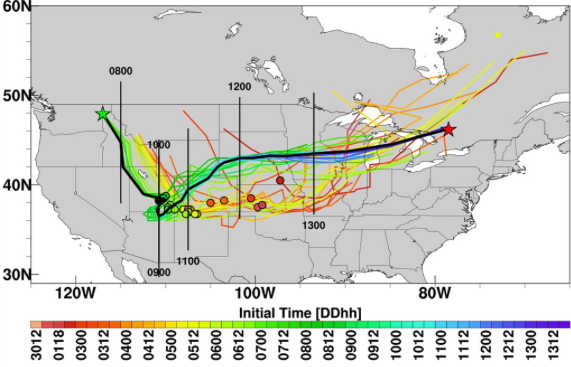

Citation: Weather and Forecasting 38, 10; 10.1175/WAF-D-22-0224.1

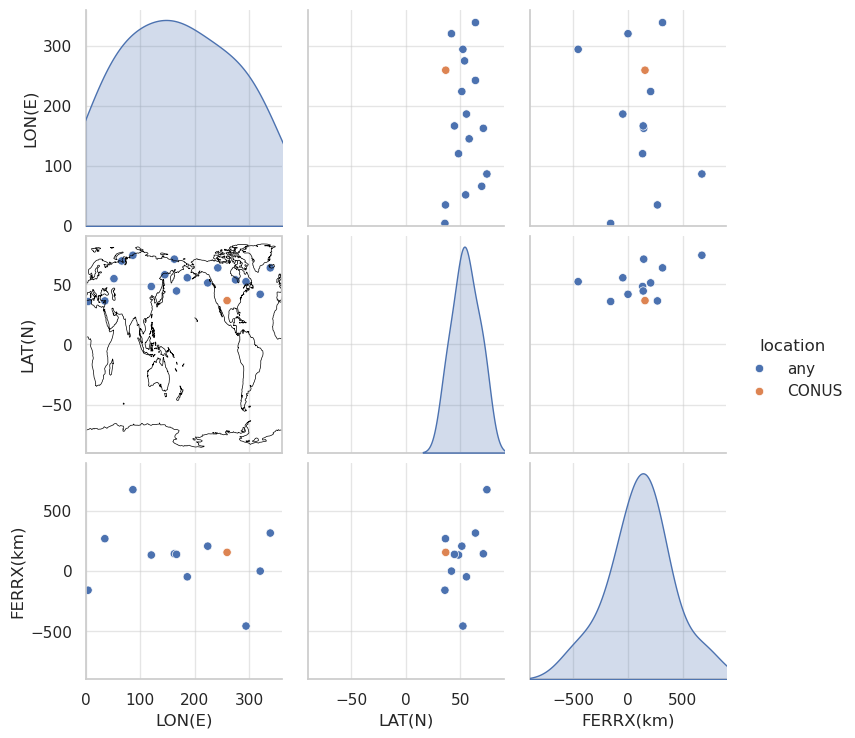

In [10]:
fp = sns.pairplot(
    df[(df["ITIME"] == ITIME) & (df["FHOUR"] >= 72) & (df["LAT(N)"] >= 0)],
    vars=["LON(E)", "LAT(N)", "FERRX(km)"],
    hue="location",
)
fix_axes(fp)

In [12]:
df[(df["ITIME"] == ITIME) & (df["FHOUR"] >= 72)].groupby("location").describe()["FERRX(km)"]

Empty DataFrame
Columns: [count, mean, min, 25%, 50%, 75%, max, std]
Index: []

In [13]:
df[df["FHOUR"] >= 72].groupby("location").describe()["FERRX(km)"]

count        mean      min       25%      50%       75%       max  \
location                                                                        
CONUS       414.0   50.019541 -3460.12 -212.8875   86.425  302.8225   1885.37   
Lupo2023    196.0  584.148418  -428.73  275.7950  502.580  779.7825   2045.63   
any       12720.0  -13.191969 -5860.40 -318.4025    0.000  297.6900  10834.62   

                 std  
location              
CONUS     624.168621  
Lupo2023  490.485403  
any       762.289955

In [14]:
df[df["FHOUR"] >= 72].groupby("location").describe()["FERRX(km)"]

count        mean      min       25%      50%       75%       max  \
location                                                                        
CONUS       414.0   50.019541 -3460.12 -212.8875   86.425  302.8225   1885.37   
Lupo2023    196.0  584.148418  -428.73  275.7950  502.580  779.7825   2045.63   
any       12720.0  -13.191969 -5860.40 -318.4025    0.000  297.6900  10834.62   

                 std  
location              
CONUS     624.168621  
Lupo2023  490.485403  
any       762.289955

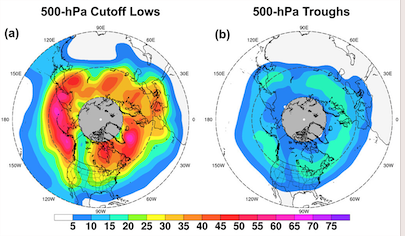

Citation: Weather and Forecasting 38, 10; 10.1175/WAF-D-22-0224.1

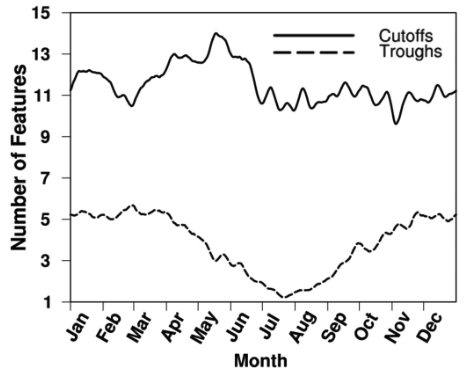

https://journals.ametsoc.org/view/journals/wefo/38/10/full-WAF-D-22-0224.1-f7.jpg

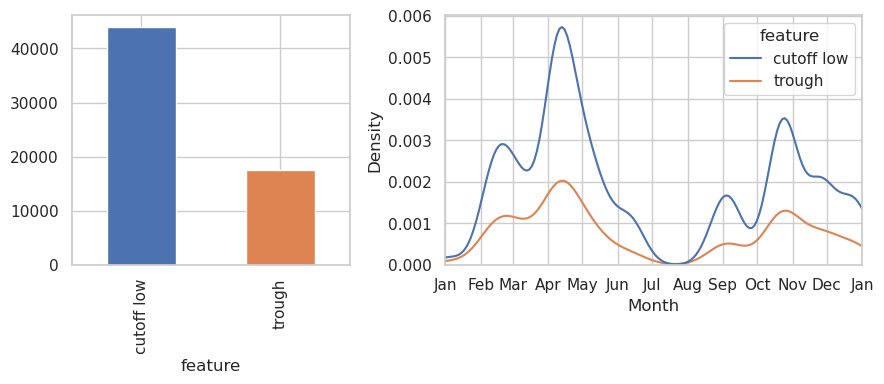

In [15]:
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

df["dayofyear"] = df["ITIME"].dt.dayofyear
fig, axes = plt.subplots(ncols=2, figsize=(9, 4), width_ratios=[2, 3])
df["feature"].value_counts().plot(kind="bar", color=["C0", "C1"], ax=axes[0])
ax = axes[1]
ax = sns.kdeplot(df, x="dayofyear", hue="feature", ax=ax)
ax.set_xlabel("Month")
date_form = DateFormatter("%b")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.set_xlim((0, 365))
plt.tight_layout()

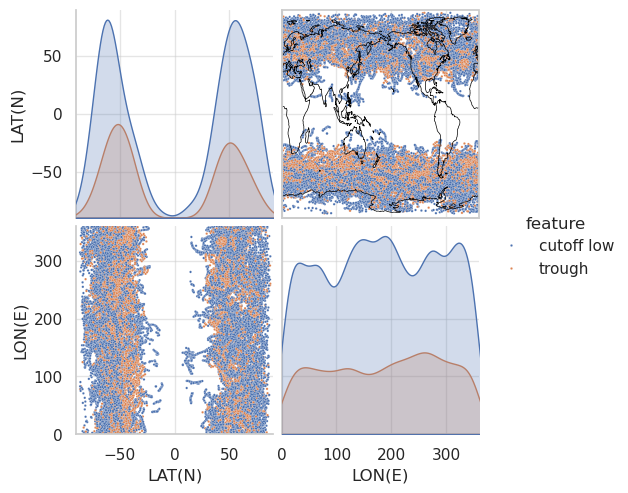

In [16]:
fp = sns.pairplot(
    df[(df["FHOUR"] >= 72)],
    vars=["LAT(N)", "LON(E)"],
    plot_kws={"s": 3},
    hue="feature",
)
fix_axes(fp)

## Divide NH zonal error into terciles (3 equal-sized groups based on value)

- high zonal error (progressive) most common over CONUS
- has greater meridional background slope

isForecast
False    Axes(0.125,0.11;0.775x0.77)
True     Axes(0.125,0.11;0.775x0.77)
Name: Ro(km), dtype: object

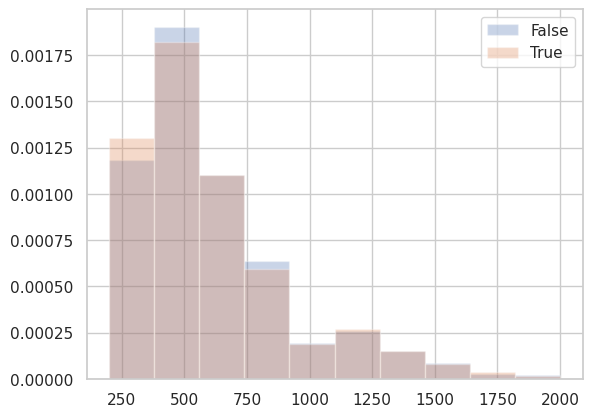

In [17]:
df["isForecast"] = df["FHOUR"] > 0
df.groupby("isForecast")["Ro(km)"].hist(density=True, alpha=0.3, legend=True)

isForecast
False    Axes(0.125,0.11;0.775x0.77)
True     Axes(0.125,0.11;0.775x0.77)
Name: T500(K), dtype: object

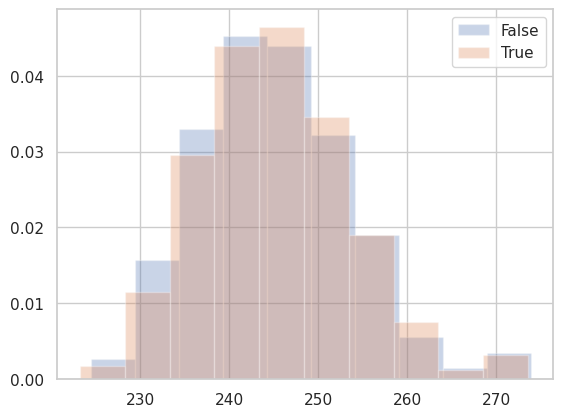

In [18]:
df.groupby("isForecast")["T500(K)"].hist(density=True, alpha=0.3, legend=True)

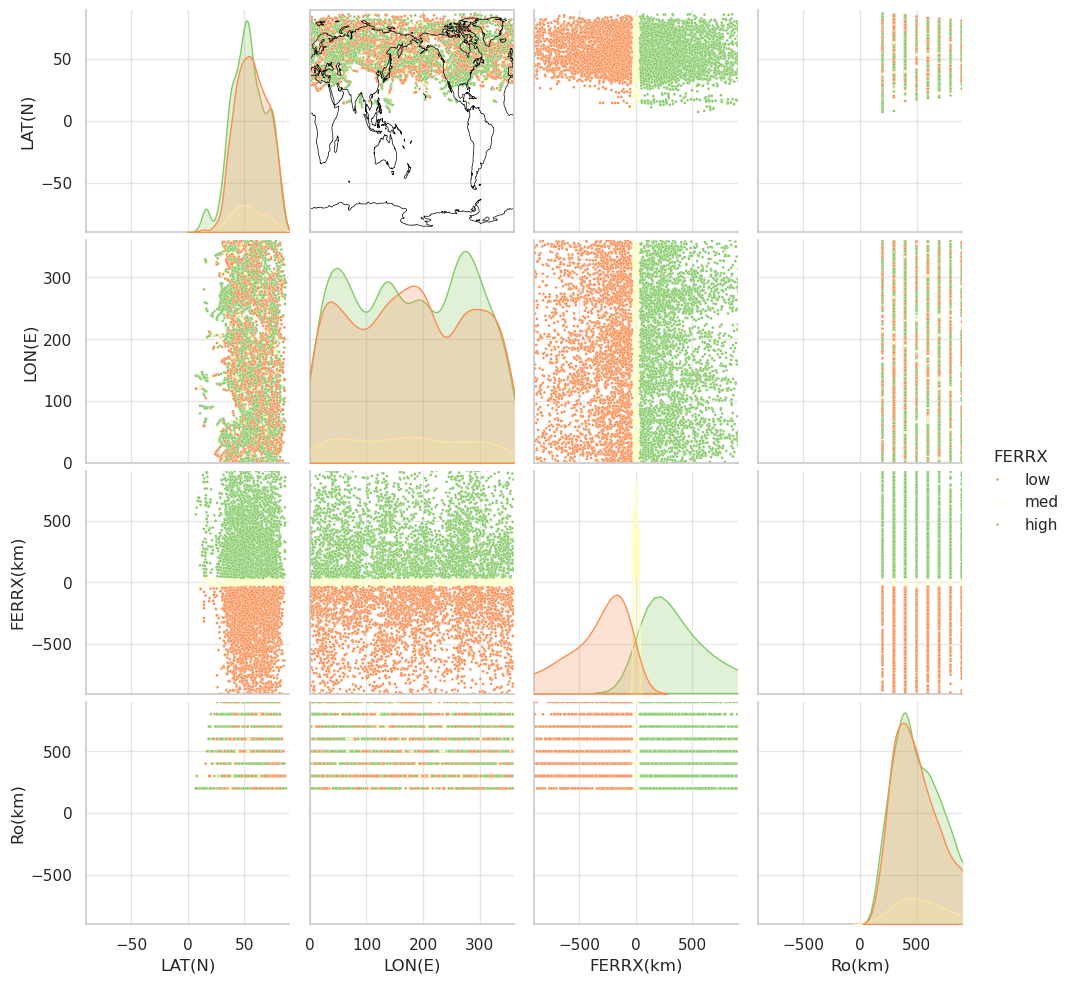

In [19]:
fp = sns.pairplot(
    df[
        (df["FHOUR"] >= 72)
        & (df["LAT(N)"] >= 0)
        # & (df["LAT(N)"] >= lat0)
        # & (df["LAT(N)"] < lat1)
        # & (df["LON(E)"] >= lon0)
        # & (df["LON(E)"] < lon1)
    ],
    vars=[
        "LAT(N)",
        "LON(E)",
        "FERRX(km)",
        #        "FERRY(km)",
        #        "BGo-lon(m/100km)",
        #        "BGo-lat(m/100km)",
        "Ro(km)",
    ],
    plot_kws={"s": 4},
    hue="FERRX",
    palette="RdYlGn",
)
fix_axes(fp)

In [20]:
df[df["FHOUR"] >= 72].describe().loc["mean"]

ITIME               2021-01-01 03:29:39.059456512
FHOUR                                  152.313691
ID                                   41244.663439
So(m/100km)                             18.233408
LAT(N)                                   1.557685
LON(E)                                 183.501629
SoFlag                                  -0.428626
Ro(km)                                 590.010989
SR                                        0.97651
BGo(m/100km)                            16.368753
BGo-lat(m/100km)                         1.779235
BGo-lon(m/100km)                         0.794555
ZMIN(m)                               5186.784187
ZLAT(N)                                  3.466459
ZLON(E)                                182.360647
Z850(m)                               1294.731145
Z500(m)                               5281.761957
Z200(m)                              11413.249176
T850(K)                                267.295293
T500(K)                                244.955451


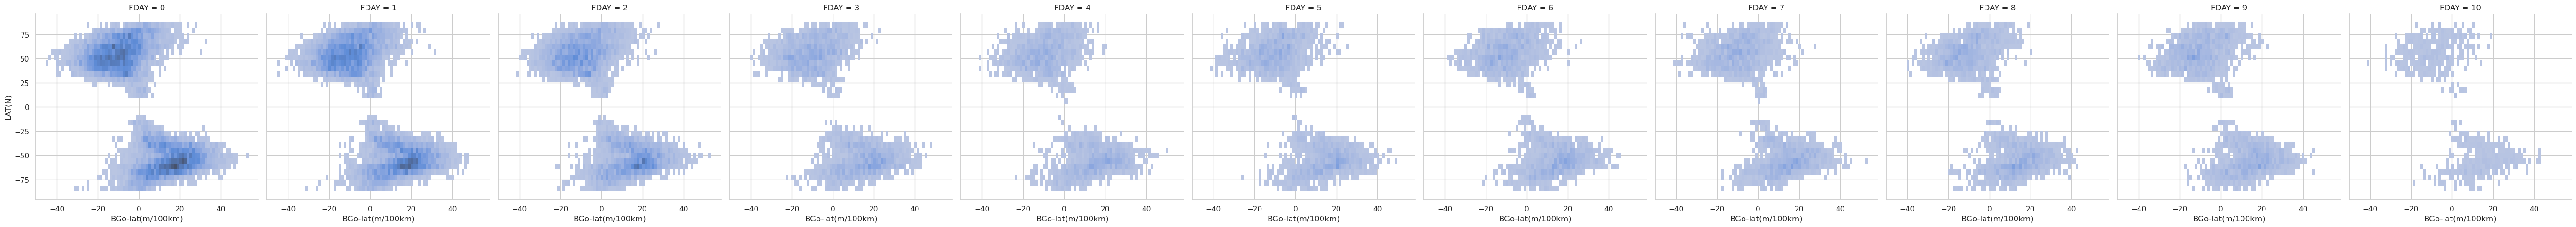

In [27]:
sns.displot(data=df, x="BGo-lat(m/100km)", y="LAT(N)", col="FDAY")

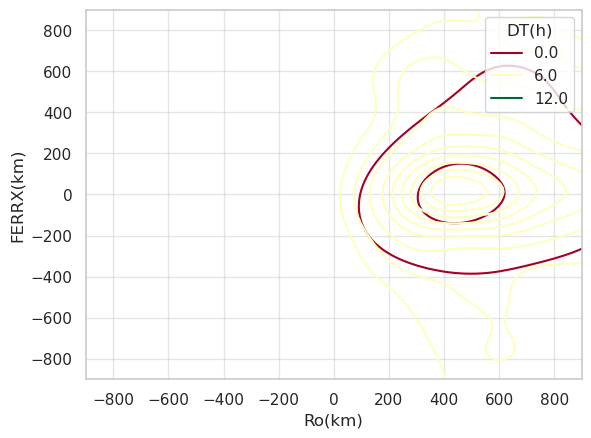

In [29]:
fix_axes(
    sns.kdeplot(
        data=df[df.location == "CONUS"],
        x="Ro(km)",
        y="FERRX(km)",
        hue="DT(h)",
        palette="RdYlGn",
    )
)

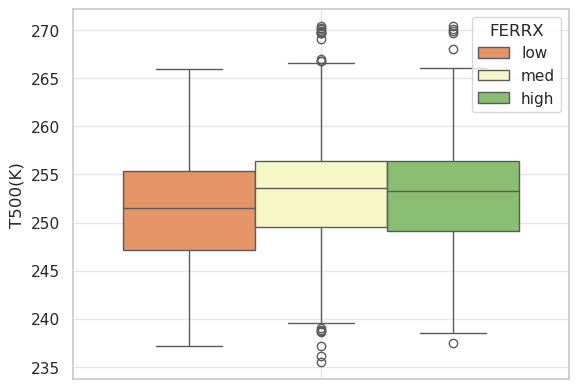

In [23]:
fp = sns.boxplot(
    data=df[df.location == "CONUS"],
    hue="FERRX",
    y="T500(K)",
    palette="RdYlGn",
)
fix_axes(fp)

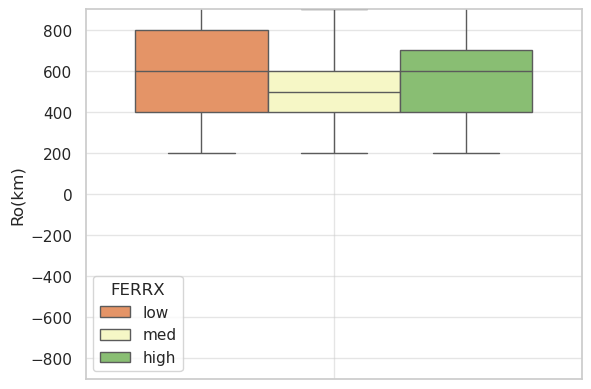

In [31]:
fp = sns.boxplot(
    data=df[df.location == "CONUS"],
    hue="FERRX",
    y="Ro(km)",
    palette="RdYlGn",
)
fix_axes(fp)

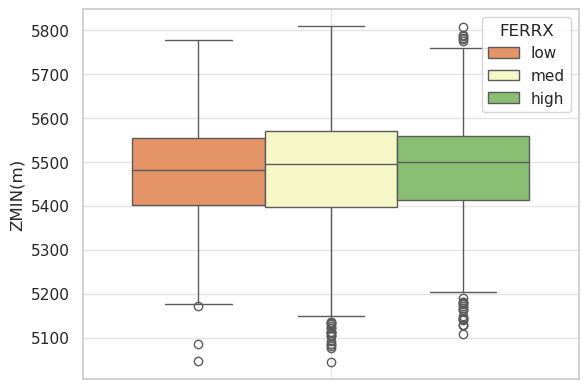

In [32]:
fp = sns.boxplot(
    data=df[df.location == "CONUS"],
    hue="FERRX",
    y="ZMIN(m)",
    palette="RdYlGn",
)
fix_axes(fp)

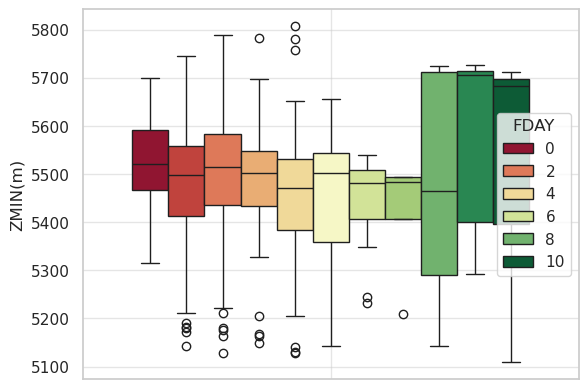

In [33]:
fp = sns.boxplot(
    data=df[(df.location == "CONUS") & (df.FERRX == "high")],
    hue="FDAY",
    y="ZMIN(m)",
    palette="RdYlGn",
)
fix_axes(fp)